<a href="https://colab.research.google.com/github/lamtung1997/Solving_PDEs_Deep_learning/blob/main/5_Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SETUP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import math
import itertools
import os
import logging
from numpy import loadtxt
import matplotlib.pyplot as plt

# number pi
pi = math.pi

# random_seed
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# DATA

dt = 0.5                    # time-step
T = 5                       # T
nots = int(T/dt) + 1        # number of time steps
P_in, P_b, P_up = [], [], []

n = 40                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
for i, j, k in itertools.product(range(n), range(n), range(nots)):
    p = [c[i], c[j], k*dt]
    if(i != 0 and i != n-1 and j != 0 and j != n-1):
        P_in.append(p)

n = 450
c = np.linspace(0, 1, n)
for i, j, k in itertools.product(range(n), range(n), range(nots)):
    p = [c[i], c[j], k*dt]
    if(j == n-1 and i != 0 and i != n-1):
        P_up.append(p)
    elif(i == 0 or i == n-1 or j == 0):
        P_b.append(p)

# upsampling P_up that its size is equal to P_in
for i in range(len(P_in)-len(P_up)):
    j = i%(len(P_up))
    P_up.append(P_up[j])

# upsampling P_b that its size is equal to P_in
for i in range(len(P_in)-len(P_b)):
    j = i%(len(P_b))
    P_b.append(P_b[j])

# convert numpy array, P_in and P_border to Tensorflow Dataset
P_in = tf.convert_to_tensor(P_in, dtype=tf.float32)
P_up = tf.convert_to_tensor(P_up, dtype=tf.float32)
P_b = tf.convert_to_tensor(P_b, dtype=tf.float32)

batch_size = 16

P_in = tf.data.Dataset.from_tensor_slices((P_in))
P_in = P_in.shuffle(buffer_size=int(len(P_in))).batch(batch_size).prefetch(64).cache()

P_up = tf.data.Dataset.from_tensor_slices((P_up))
P_up = P_up.shuffle(buffer_size=int(len(P_up))).batch(batch_size).prefetch(64).cache()

P_b = tf.data.Dataset.from_tensor_slices((P_b))
P_b = P_b.shuffle(buffer_size=int(len(P_b))).batch(batch_size).prefetch(64).cache()

print("Number of data:", P_in.cardinality().numpy()*3)

Number of data: 2979


In [ ]:
# MODEL
nn = 32
inputs = keras.Input(shape=(3,), name='points')
hidden_1 = layers.Dense(nn, activation='sigmoid', name='hidden_1')(inputs)
hidden_2 = layers.Dense(nn, activation='sigmoid', name='hidden_2')(hidden_1)
hidden_3 = layers.Dense(nn, activation='tanh', name='hidden_3')(hidden_2)
hidden_4 = layers.Dense(nn, activation='tanh', name='hidden_4')(hidden_3)
# hidden_5 = layers.Dense(nn, activation='tanh', name='hidden_5')(hidden_4)
# hidden_6 = layers.Dense(nn, activation='tanh', name='hidden_6')(hidden_5)
# hidden_7 = layers.Dense(nn, activation='tanh', name='hidden_7')(hidden_6)
# hidden_8 = layers.Dense(nn, activation='tanh', name='hidden_8')(hidden_7)
outputs = layers.Dense(3, activation='linear', name="u_v_p")(hidden_4)
model = keras.Model(inputs=inputs, outputs=outputs, name='navier-stokes')
model.summary()

Model: "navier-stokes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                128       
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
u_v_p (Dense)                (None, 3)                 99        
Total params: 3,395
Trainable params: 3,395
Non-trainable params: 0
___________________________________________________

In [ ]:
def show(t):
    plt.figure(figsize=(4, 4), dpi=80)

    n = 10
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)

    u = np.zeros(shape=(n,n), dtype=float)
    v = np.zeros(shape=(n,n), dtype=float)

    for i in range(n):
        for j in range(n):
            z = tf.convert_to_tensor([[x[i], y[j], t]])
            u1, v1 = model(z).numpy()[0][0:2]
            u[j,i] = u1
            v[j,i] = v1

    plt.streamplot(x, y, u, v, color=u*10, linewidth=0.5, arrowsize=0.25, density=2)
    plt.show()

In [ ]:
# CHOOSE OPTIMIZER
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# TRAIN FUNCTION
@tf.function
def train_step(P_in, P_up, P_b):
    loss_in, loss_up, loss_b = [0], [0], [0]
    with tf.GradientTape(persistent=True) as tape:
        # interior loss
        for i in range(P_in.shape[0]):
            z = tf.reshape(P_in[i], shape=(1,3))
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(z)
                with tf.GradientTape(persistent=True) as tape2:  
                    tape2.watch(z)

                    # calculating u_xx, u_yy, v_xx, v_yy, p_x, p_y
                    u = model(z)[0][0]
                    v = model(z)[0][1]
                    p = model(z)[0][2]

                u_x = tape2.gradient(u, z)[0][0]
                u_y = tape2.gradient(u, z)[0][1]
                u_t = tape2.gradient(u, z)[0][2]
                v_x = tape2.gradient(v, z)[0][0]
                v_y = tape2.gradient(v, z)[0][1]
                v_t = tape2.gradient(v, z)[0][2]
                p_x = tape2.gradient(p, z)[0][0]
                p_y = tape2.gradient(p, z)[0][1]
            
            u_xx = tape1.gradient(u_x, z)[0][0]
            u_yy = tape1.gradient(u_y, z)[0][1]
            v_xx = tape1.gradient(v_x, z)[0][0]
            v_yy = tape1.gradient(v_y, z)[0][1]

            # calculating loss_in
            nu = 0.01
            loss1 = tf.math.square(u_t - nu*(u_xx + u_yy) + u*u_x + v*u_y + p_x)
            loss2 = tf.math.square(v_t - nu*(v_xx + v_yy) + u*v_x + v*v_y + p_y)
            loss3 = tf.math.square(u_x + v_y)
            # loss_ini = tf.math.square(u - u*tf.math.ceil(z[0][2]*z[0][2])) + tf.math.square(v - v*tf.math.ceil(z[0][2]*z[0][2]))
            loss_in += loss1 + loss2 + loss3

        # upper boundary loss
        for j in range(P_up.shape[0]):
            z = tf.reshape(P_up[j], shape=(1,3))

            # calculating u,v
            u = model(z)[0][0]
            v = model(z)[0][1]

            # calculating loss_up
            loss_up += tf.math.square(u-1) + tf.math.square(v)

        # other boundaries loss
        for j in range(P_b.shape[0]):
            z = tf.reshape(P_b[j], shape=(1,3))

            # calculating u,v
            u = model(z)[0][0]
            v = model(z)[0][1]

            # calculating loss_up
            loss_b += tf.math.square(u) + tf.math.square(v)
        
        # loss function
        batch_loss = loss_in + loss_up + loss_b
    
    # update weights
    grads = tape.gradient(batch_loss, model.trainable_weights)          # gradient of loss function with respect to w
    optimizer.apply_gradients(zip(grads, model.trainable_weights))      # update w

    return batch_loss

In [ ]:
# TRAIN FUNCTION
losses = []
def train(learning_rate):
    optimizer.learning_rate.assign(learning_rate)
    loss = 0
    for (P_in_batch, P_up_batch, P_b_batch) in itertools.zip_longest(P_in, P_up, P_b):
        batch_loss = train_step(P_in_batch, P_up_batch, P_b_batch)
        loss += batch_loss
    losses.append(loss.numpy())

Learning rate: 0.001
[  0] loss =  3449.5344238 	 106.383s 	 less than 3546.106 minutes to finish


[  1] loss =  2065.8725586 	 25.884s 	 less than 862.380 minutes to finish
[  2] loss =   932.5858154 	 26.010s 	 less than 866.134 minutes to finish
[  3] loss =   742.7536621 	 25.839s 	 less than 859.995 minutes to finish
[  4] loss =   679.8370972 	 26.117s 	 less than 868.837 minutes to finish
[  5] loss =   644.9938354 	 26.250s 	 less than 872.828 minutes to finish
[  6] loss =   626.0183105 	 26.165s 	 less than 869.560 minutes to finish
[  7] loss =   614.2379150 	 26.004s 	 less than 863.777 minutes to finish
[  8] loss =   606.0499268 	 26.539s 	 less than 881.085 minutes to finish
[  9] loss =   598.6777954 	 25.792s 	 less than 855.851 minutes to finish
[ 10] loss =   591.4254150 	 25.667s 	 less than 851.285 minutes to finish


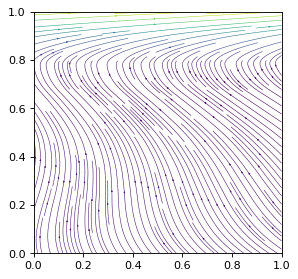

[ 11] loss =   585.2943115 	 25.833s 	 less than 856.363 minutes to finish
[ 12] loss =   579.9141846 	 26.504s 	 less than 878.162 minutes to finish
[ 13] loss =   574.9506226 	 25.802s 	 less than 854.477 minutes to finish
[ 14] loss =   570.2418823 	 25.836s 	 less than 855.184 minutes to finish
[ 15] loss =   565.7230835 	 26.844s 	 less than 888.102 minutes to finish
[ 16] loss =   561.3673096 	 25.899s 	 less than 856.405 minutes to finish
[ 17] loss =   557.1679077 	 25.886s 	 less than 855.538 minutes to finish
[ 18] loss =   553.1525269 	 26.550s 	 less than 877.029 minutes to finish
[ 19] loss =   549.3551025 	 25.991s 	 less than 858.134 minutes to finish
[ 20] loss =   545.7993164 	 25.956s 	 less than 856.545 minutes to finish


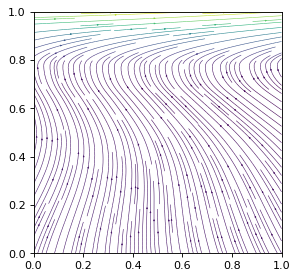

[ 21] loss =   542.4923096 	 26.634s 	 less than 878.463 minutes to finish
[ 22] loss =   539.4076538 	 26.539s 	 less than 874.889 minutes to finish
[ 23] loss =   536.5207520 	 26.772s 	 less than 882.145 minutes to finish
[ 24] loss =   533.8280640 	 26.259s 	 less than 864.783 minutes to finish
[ 25] loss =   531.3208618 	 26.317s 	 less than 866.279 minutes to finish
[ 26] loss =   528.9739990 	 26.439s 	 less than 869.842 minutes to finish
[ 27] loss =   526.7704468 	 26.085s 	 less than 857.756 minutes to finish
[ 28] loss =   524.6963501 	 25.900s 	 less than 851.260 minutes to finish
[ 29] loss =   522.7375488 	 25.951s 	 less than 852.501 minutes to finish
[ 30] loss =   520.8853149 	 26.255s 	 less than 862.042 minutes to finish


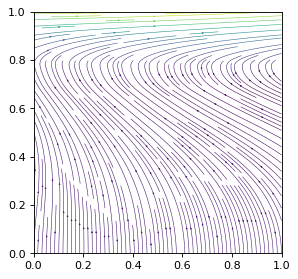

[ 31] loss =   519.1287842 	 26.292s 	 less than 862.800 minutes to finish
[ 32] loss =   517.4596558 	 25.574s 	 less than 838.817 minutes to finish
[ 33] loss =   515.8700562 	 25.850s 	 less than 847.458 minutes to finish
[ 34] loss =   514.3649292 	 26.463s 	 less than 867.090 minutes to finish
[ 35] loss =   512.9223633 	 25.806s 	 less than 845.146 minutes to finish
[ 36] loss =   511.5190125 	 25.772s 	 less than 843.598 minutes to finish
[ 37] loss =   510.1280518 	 26.166s 	 less than 856.050 minutes to finish
[ 38] loss =   508.7319946 	 25.841s 	 less than 845.010 minutes to finish
[ 39] loss =   507.3269653 	 26.065s 	 less than 851.893 minutes to finish
[ 40] loss =   505.9180908 	 25.955s 	 less than 847.858 minutes to finish


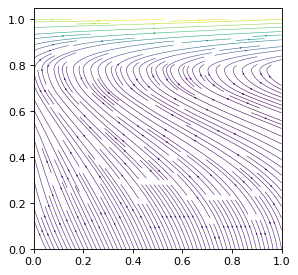

[ 41] loss =   504.5036011 	 26.407s 	 less than 862.186 minutes to finish
[ 42] loss =   503.0760498 	 25.631s 	 less than 836.431 minutes to finish
[ 43] loss =   501.6323547 	 25.970s 	 less than 847.049 minutes to finish
[ 44] loss =   500.1747131 	 25.865s 	 less than 843.204 minutes to finish
[ 45] loss =   498.7153015 	 25.845s 	 less than 842.108 minutes to finish
[ 46] loss =   497.2673645 	 25.663s 	 less than 835.753 minutes to finish
[ 47] loss =   495.8450012 	 25.760s 	 less than 838.486 minutes to finish
[ 48] loss =   494.4632263 	 26.015s 	 less than 846.342 minutes to finish
[ 49] loss =   493.1275330 	 25.928s 	 less than 843.088 minutes to finish
[ 50] loss =   491.8541870 	 25.792s 	 less than 838.236 minutes to finish


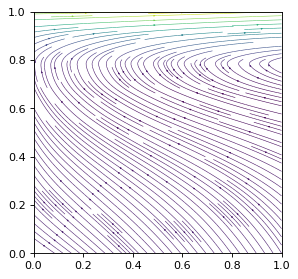

[ 51] loss =   490.6353455 	 25.771s 	 less than 837.139 minutes to finish
[ 52] loss =   489.4602051 	 25.724s 	 less than 835.170 minutes to finish
[ 53] loss =   488.3067322 	 26.206s 	 less than 850.374 minutes to finish
[ 54] loss =   487.1668701 	 25.756s 	 less than 835.353 minutes to finish
[ 55] loss =   486.0351868 	 25.707s 	 less than 833.331 minutes to finish
[ 56] loss =   484.9183960 	 25.757s 	 less than 834.525 minutes to finish
[ 57] loss =   483.8272095 	 25.704s 	 less than 832.376 minutes to finish
[ 58] loss =   482.7712708 	 25.758s 	 less than 833.708 minutes to finish
[ 59] loss =   481.7546082 	 25.803s 	 less than 834.714 minutes to finish
[ 60] loss =   480.7783813 	 25.605s 	 less than 827.904 minutes to finish


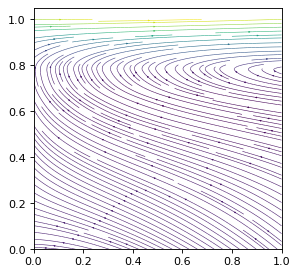

[ 61] loss =   479.8385620 	 25.829s 	 less than 834.712 minutes to finish
[ 62] loss =   478.9282227 	 25.797s 	 less than 833.252 minutes to finish
[ 63] loss =   478.0374146 	 25.831s 	 less than 833.918 minutes to finish
[ 64] loss =   477.1585083 	 26.051s 	 less than 840.568 minutes to finish
[ 65] loss =   476.2827148 	 26.380s 	 less than 850.752 minutes to finish
[ 66] loss =   475.3969727 	 25.686s 	 less than 827.945 minutes to finish
[ 67] loss =   474.4888306 	 25.820s 	 less than 831.827 minutes to finish
[ 68] loss =   473.5429382 	 25.588s 	 less than 823.948 minutes to finish
[ 69] loss =   472.5395203 	 25.901s 	 less than 833.580 minutes to finish
[ 70] loss =   471.4522705 	 25.758s 	 less than 828.561 minutes to finish


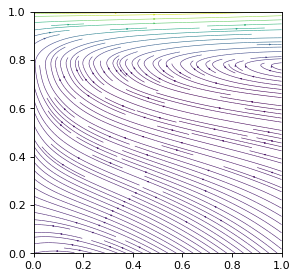

[ 71] loss =   470.2423401 	 25.615s 	 less than 823.506 minutes to finish
[ 72] loss =   468.8609314 	 27.232s 	 less than 875.057 minutes to finish
[ 73] loss =   467.2614441 	 26.315s 	 less than 845.141 minutes to finish
[ 74] loss =   465.3933411 	 26.079s 	 less than 837.149 minutes to finish
[ 75] loss =   463.2183228 	 25.501s 	 less than 818.169 minutes to finish
[ 76] loss =   460.6084900 	 25.606s 	 less than 821.084 minutes to finish
[ 77] loss =   457.6387634 	 25.832s 	 less than 827.917 minutes to finish
[ 78] loss =   454.2962036 	 25.352s 	 less than 812.114 minutes to finish
[ 79] loss =   450.6356812 	 26.132s 	 less than 836.660 minutes to finish
[ 80] loss =   446.6748962 	 25.794s 	 less than 825.411 minutes to finish


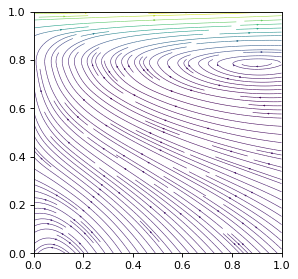

[ 81] loss =   442.6571045 	 25.627s 	 less than 819.649 minutes to finish
[ 82] loss =   438.7235413 	 25.396s 	 less than 811.817 minutes to finish
[ 83] loss =   435.1602783 	 25.869s 	 less than 826.525 minutes to finish
[ 84] loss =   432.0368652 	 25.723s 	 less than 821.414 minutes to finish
[ 85] loss =   429.3215027 	 26.112s 	 less than 833.424 minutes to finish
[ 86] loss =   426.9369812 	 25.357s 	 less than 808.895 minutes to finish
[ 87] loss =   424.8065796 	 25.673s 	 less than 818.533 minutes to finish
[ 88] loss =   422.7457886 	 26.073s 	 less than 830.844 minutes to finish
[ 89] loss =   420.8286743 	 25.940s 	 less than 826.186 minutes to finish
[ 90] loss =   419.0058289 	 25.451s 	 less than 810.201 minutes to finish


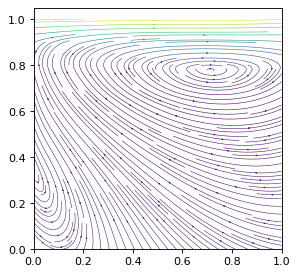

[ 91] loss =   417.1531677 	 26.346s 	 less than 838.238 minutes to finish
[ 92] loss =   415.4075317 	 25.589s 	 less than 813.720 minutes to finish
[ 93] loss =   413.6608887 	 25.405s 	 less than 807.450 minutes to finish
[ 94] loss =   411.9847717 	 26.648s 	 less than 846.505 minutes to finish
[ 95] loss =   410.2890625 	 25.992s 	 less than 825.249 minutes to finish
[ 96] loss =   408.6427612 	 25.688s 	 less than 815.173 minutes to finish
[ 97] loss =   406.9424133 	 26.082s 	 less than 827.220 minutes to finish
[ 98] loss =   405.2573242 	 25.933s 	 less than 822.066 minutes to finish
[ 99] loss =   403.5154114 	 25.630s 	 less than 812.041 minutes to finish
[100] loss =   401.7027893 	 25.499s 	 less than 807.484 minutes to finish


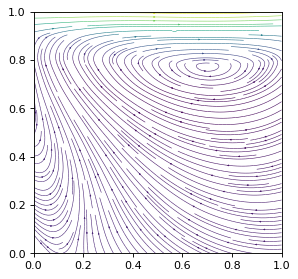

[101] loss =   399.8044434 	 25.910s 	 less than 820.061 minutes to finish
[102] loss =   397.7893372 	 25.908s 	 less than 819.549 minutes to finish
[103] loss =   395.6494446 	 25.913s 	 less than 819.268 minutes to finish
[104] loss =   393.3891602 	 25.807s 	 less than 815.495 minutes to finish
[105] loss =   391.0329285 	 25.980s 	 less than 820.549 minutes to finish
[106] loss =   388.6713257 	 25.948s 	 less than 819.090 minutes to finish
[107] loss =   386.3971863 	 25.724s 	 less than 811.595 minutes to finish
[108] loss =   384.4930725 	 25.989s 	 less than 819.531 minutes to finish
[109] loss =   383.1861572 	 26.051s 	 less than 821.041 minutes to finish
[110] loss =   382.3243713 	 25.621s 	 less than 807.057 minutes to finish


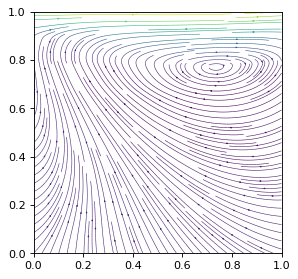

[111] loss =   381.3082886 	 26.084s 	 less than 821.207 minutes to finish
[112] loss =   379.9839783 	 25.553s 	 less than 804.081 minutes to finish
[113] loss =   378.9216309 	 26.362s 	 less than 829.091 minutes to finish
[114] loss =   377.7414551 	 26.134s 	 less than 821.477 minutes to finish
[115] loss =   376.9670105 	 25.720s 	 less than 808.052 minutes to finish
[116] loss =   375.9081116 	 25.574s 	 less than 803.033 minutes to finish
[117] loss =   375.2596436 	 25.982s 	 less than 815.405 minutes to finish
[118] loss =   374.2850342 	 25.743s 	 less than 807.460 minutes to finish
[119] loss =   373.5913696 	 25.973s 	 less than 814.269 minutes to finish
[120] loss =   372.6917114 	 25.905s 	 less than 811.676 minutes to finish


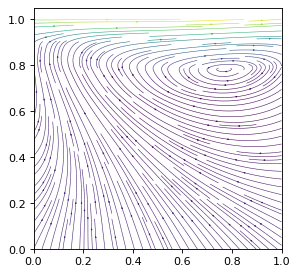

[121] loss =   371.8143616 	 26.392s 	 less than 826.518 minutes to finish
[122] loss =   371.0051575 	 26.014s 	 less than 814.246 minutes to finish
[123] loss =   370.0293884 	 26.343s 	 less than 824.093 minutes to finish
[124] loss =   369.1960144 	 26.538s 	 less than 829.761 minutes to finish
[125] loss =   368.2665100 	 26.372s 	 less than 824.131 minutes to finish
[126] loss =   367.3389282 	 25.855s 	 less than 807.533 minutes to finish
[127] loss =   366.3825378 	 26.134s 	 less than 815.815 minutes to finish
[128] loss =   365.4050903 	 26.224s 	 less than 818.190 minutes to finish
[129] loss =   364.4562683 	 25.956s 	 less than 809.380 minutes to finish
[130] loss =   363.5340271 	 25.973s 	 less than 809.482 minutes to finish


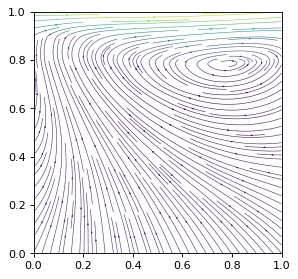

[131] loss =   362.6376648 	 26.029s 	 less than 810.812 minutes to finish
[132] loss =   361.7038269 	 26.327s 	 less than 819.640 minutes to finish
[133] loss =   360.8104248 	 26.102s 	 less than 812.194 minutes to finish
[134] loss =   359.8848877 	 26.107s 	 less than 811.919 minutes to finish
[135] loss =   359.0106812 	 26.166s 	 less than 813.312 minutes to finish
[136] loss =   358.0943909 	 25.914s 	 less than 805.056 minutes to finish
[137] loss =   357.1824951 	 25.997s 	 less than 807.218 minutes to finish
[138] loss =   356.2513428 	 25.375s 	 less than 787.472 minutes to finish
[139] loss =   355.2899780 	 25.777s 	 less than 799.532 minutes to finish
[140] loss =   354.3173523 	 25.756s 	 less than 798.428 minutes to finish


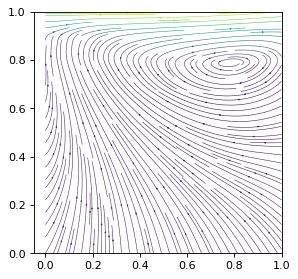

[141] loss =   353.3053589 	 25.696s 	 less than 796.151 minutes to finish
[142] loss =   352.2455750 	 26.342s 	 less than 815.716 minutes to finish
[143] loss =   351.1821594 	 25.594s 	 less than 792.128 minutes to finish
[144] loss =   350.1366882 	 26.107s 	 less than 807.568 minutes to finish
[145] loss =   349.0373230 	 25.404s 	 less than 785.405 minutes to finish
[146] loss =   347.8731995 	 25.469s 	 less than 787.003 minutes to finish
[147] loss =   346.7615356 	 25.722s 	 less than 794.395 minutes to finish
[148] loss =   345.7028809 	 26.572s 	 less than 820.199 minutes to finish
[149] loss =   344.5794067 	 25.805s 	 less than 796.074 minutes to finish
[150] loss =   343.4113770 	 25.834s 	 less than 796.543 minutes to finish


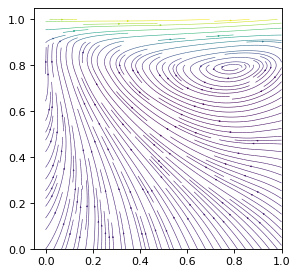

[151] loss =   342.2981873 	 25.692s 	 less than 791.731 minutes to finish
[152] loss =   341.1352844 	 26.213s 	 less than 807.373 minutes to finish
[153] loss =   339.9639282 	 25.747s 	 less than 792.586 minutes to finish
[154] loss =   338.7759705 	 26.005s 	 less than 800.090 minutes to finish
[155] loss =   337.5795288 	 26.495s 	 less than 814.734 minutes to finish
[156] loss =   336.3605652 	 25.829s 	 less than 793.798 minutes to finish
[157] loss =   335.0687866 	 25.538s 	 less than 784.432 minutes to finish
[158] loss =   333.8008728 	 25.780s 	 less than 791.441 minutes to finish
[159] loss =   332.5032349 	 25.582s 	 less than 784.933 minutes to finish
[160] loss =   331.1963806 	 26.084s 	 less than 799.918 minutes to finish


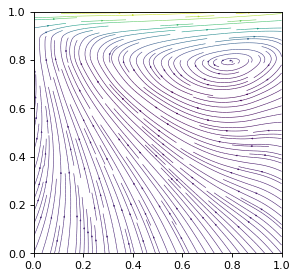

[161] loss =   329.8771973 	 26.127s 	 less than 800.780 minutes to finish
[162] loss =   328.5452271 	 26.144s 	 less than 800.867 minutes to finish
[163] loss =   327.2028198 	 25.868s 	 less than 791.999 minutes to finish
[164] loss =   325.8542480 	 25.844s 	 less than 790.823 minutes to finish
[165] loss =   324.5035400 	 25.930s 	 less than 793.026 minutes to finish
[166] loss =   323.1550903 	 25.928s 	 less than 792.536 minutes to finish
[167] loss =   321.8125916 	 26.025s 	 less than 795.078 minutes to finish
[168] loss =   320.4781189 	 26.006s 	 less than 794.054 minutes to finish
[169] loss =   319.1557312 	 26.294s 	 less than 802.416 minutes to finish
[170] loss =   317.8456726 	 25.878s 	 less than 789.266 minutes to finish


[171] loss =   316.5478210 	 25.935s 	 less than 790.584 minutes to finish
[172] loss =   315.2610474 	 26.013s 	 less than 792.534 minutes to finish
[173] loss =   313.9858093 	 26.031s 	 less than 792.653 minutes to finish
[174] loss =   312.7200012 	 25.943s 	 less than 789.521 minutes to finish
[175] loss =   311.4611511 	 26.132s 	 less than 794.864 minutes to finish
[176] loss =   310.2031860 	 26.216s 	 less than 796.952 minutes to finish
[177] loss =   308.9411621 	 25.722s 	 less than 781.511 minutes to finish
[178] loss =   307.6699524 	 25.450s 	 less than 772.838 minutes to finish
[179] loss =   306.3822021 	 25.938s 	 less than 787.208 minutes to finish
[180] loss =   305.0711365 	 25.811s 	 less than 782.946 minutes to finish


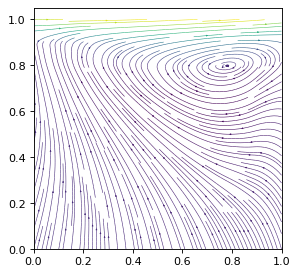

[181] loss =   303.7296448 	 26.138s 	 less than 792.413 minutes to finish
[182] loss =   302.3474731 	 25.756s 	 less than 780.414 minutes to finish
[183] loss =   300.9084473 	 25.878s 	 less than 783.685 minutes to finish
[184] loss =   299.4174500 	 26.201s 	 less than 793.024 minutes to finish
[185] loss =   297.9031982 	 25.634s 	 less than 775.420 minutes to finish
[186] loss =   296.2519531 	 25.872s 	 less than 782.202 minutes to finish
[187] loss =   294.5523071 	 25.895s 	 less than 782.454 minutes to finish
[188] loss =   292.6896667 	 25.749s 	 less than 777.632 minutes to finish
[189] loss =   290.6901855 	 26.520s 	 less than 800.457 minutes to finish
[190] loss =   288.5120544 	 25.929s 	 less than 782.197 minutes to finish


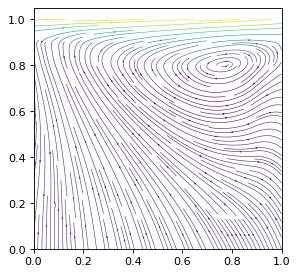

[191] loss =   286.1676636 	 26.418s 	 less than 796.499 minutes to finish
[192] loss =   283.6375427 	 26.041s 	 less than 784.703 minutes to finish
[193] loss =   280.9376526 	 26.255s 	 less than 790.703 minutes to finish
[194] loss =   278.0552063 	 26.378s 	 less than 793.989 minutes to finish
[195] loss =   275.0681458 	 26.188s 	 less than 787.808 minutes to finish
[196] loss =   272.0316162 	 26.161s 	 less than 786.572 minutes to finish
[197] loss =   269.0644836 	 25.597s 	 less than 769.202 minutes to finish
[198] loss =   267.2634888 	 25.624s 	 less than 769.587 minutes to finish
[199] loss =   267.1665344 	 25.880s 	 less than 776.838 minutes to finish
[200] loss =   268.5766907 	 26.011s 	 less than 780.345 minutes to finish


[201] loss =   266.6910400 	 25.936s 	 less than 777.640 minutes to finish
[202] loss =   263.7004700 	 26.203s 	 less than 785.218 minutes to finish
[203] loss =   263.7219238 	 25.757s 	 less than 771.410 minutes to finish
[204] loss =   263.5594177 	 26.013s 	 less than 778.650 minutes to finish
[205] loss =   276.6696472 	 26.264s 	 less than 785.720 minutes to finish
[206] loss =   266.0101318 	 25.845s 	 less than 772.778 minutes to finish
[207] loss =   271.5902100 	 26.113s 	 less than 780.334 minutes to finish
[208] loss =   261.3614807 	 25.824s 	 less than 771.265 minutes to finish
[209] loss =   269.3197632 	 26.299s 	 less than 785.036 minutes to finish
[210] loss =   261.0563049 	 26.260s 	 less than 783.424 minutes to finish


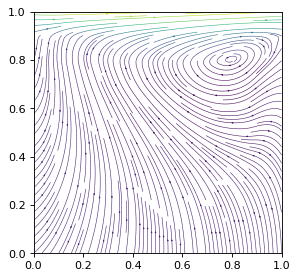

[211] loss =   266.9726868 	 25.588s 	 less than 762.960 minutes to finish
[212] loss =   264.4882202 	 26.018s 	 less than 775.340 minutes to finish
[213] loss =   263.8748474 	 25.807s 	 less than 768.615 minutes to finish
[214] loss =   264.4528198 	 26.258s 	 less than 781.618 minutes to finish
[215] loss =   264.2794800 	 26.059s 	 less than 775.267 minutes to finish
[216] loss =   264.3285522 	 25.587s 	 less than 760.778 minutes to finish
[217] loss =   264.2690125 	 25.609s 	 less than 761.001 minutes to finish
[218] loss =   262.0696411 	 26.161s 	 less than 776.996 minutes to finish
[219] loss =   263.8730164 	 26.131s 	 less than 775.664 minutes to finish
[220] loss =   263.4748230 	 26.434s 	 less than 784.220 minutes to finish


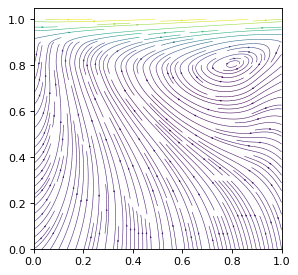

[221] loss =   260.7140503 	 26.382s 	 less than 782.217 minutes to finish
[222] loss =   260.9304199 	 25.983s 	 less than 769.957 minutes to finish
[223] loss =   260.7927856 	 26.362s 	 less than 780.742 minutes to finish
[224] loss =   266.0241089 	 26.070s 	 less than 771.673 minutes to finish
[225] loss =   258.9703369 	 25.461s 	 less than 753.218 minutes to finish
[226] loss =   254.6990204 	 26.115s 	 less than 772.140 minutes to finish
[227] loss =   256.7866211 	 25.994s 	 less than 768.129 minutes to finish
[228] loss =   264.0518799 	 25.945s 	 less than 766.255 minutes to finish
[229] loss =   253.6742249 	 25.681s 	 less than 758.008 minutes to finish
[230] loss =   260.9988708 	 25.609s 	 less than 755.476 minutes to finish


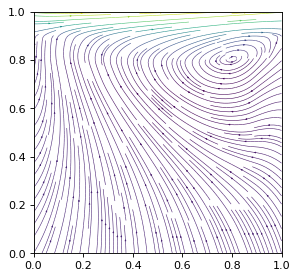

[231] loss =   257.5712891 	 25.672s 	 less than 756.905 minutes to finish
[232] loss =   258.4128418 	 26.557s 	 less than 782.547 minutes to finish
[233] loss =   254.2677307 	 25.840s 	 less than 760.977 minutes to finish
[234] loss =   261.6148071 	 25.631s 	 less than 754.399 minutes to finish
[235] loss =   250.5514832 	 26.064s 	 less than 766.720 minutes to finish
[236] loss =   246.9231415 	 25.713s 	 less than 755.962 minutes to finish
[237] loss =   247.3323975 	 26.240s 	 less than 771.012 minutes to finish
[238] loss =   245.1015625 	 26.126s 	 less than 767.219 minutes to finish
[239] loss =   243.0206451 	 26.288s 	 less than 771.549 minutes to finish
[240] loss =   243.9459534 	 26.227s 	 less than 769.327 minutes to finish


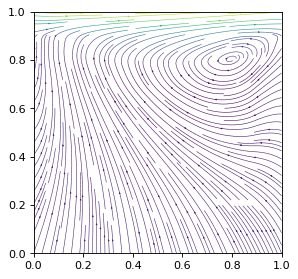

[241] loss =   241.3168640 	 26.408s 	 less than 774.197 minutes to finish
[242] loss =   239.7464600 	 26.145s 	 less than 766.038 minutes to finish
[243] loss =   235.3400879 	 26.193s 	 less than 767.015 minutes to finish
[244] loss =   231.4992371 	 26.537s 	 less than 776.659 minutes to finish
[245] loss =   245.4308929 	 26.304s 	 less than 769.403 minutes to finish
[246] loss =   280.8445129 	 26.355s 	 less than 770.456 minutes to finish
[247] loss =   236.7727966 	 26.335s 	 less than 769.425 minutes to finish
[248] loss =   244.2826233 	 26.570s 	 less than 775.849 minutes to finish
[249] loss =   249.3776093 	 27.076s 	 less than 790.169 minutes to finish
[250] loss =   241.1531219 	 26.596s 	 less than 775.720 minutes to finish


[251] loss =   274.6568298 	 26.927s 	 less than 784.929 minutes to finish
[252] loss =   241.0570221 	 26.549s 	 less than 773.467 minutes to finish
[253] loss =   242.7228699 	 26.505s 	 less than 771.750 minutes to finish
[254] loss =   239.3532867 	 26.581s 	 less than 773.512 minutes to finish
[255] loss =   235.8552246 	 26.721s 	 less than 777.146 minutes to finish
[256] loss =   230.4406128 	 26.446s 	 less than 768.697 minutes to finish
[257] loss =   304.2582397 	 26.180s 	 less than 760.521 minutes to finish

New learning rate: 0.0001
[258] loss =   160.9955444 	 26.590s 	 less than 771.996 minutes to finish
[259] loss =   140.6222687 	 26.408s 	 less than 766.276 minutes to finish
[260] loss =   130.4112701 	 26.383s 	 less than 765.121 minutes to finish


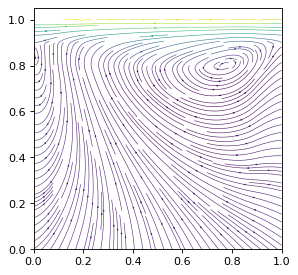

[261] loss =   127.2929001 	 26.463s 	 less than 766.976 minutes to finish
[262] loss =   125.2215500 	 25.925s 	 less than 750.958 minutes to finish
[263] loss =   123.5557175 	 26.069s 	 less than 754.702 minutes to finish
[264] loss =   122.0946960 	 25.795s 	 less than 746.340 minutes to finish
[265] loss =   120.7499771 	 26.023s 	 less than 752.509 minutes to finish
[266] loss =   119.4810028 	 26.102s 	 less than 754.353 minutes to finish
[267] loss =   118.2672348 	 26.228s 	 less than 757.557 minutes to finish
[268] loss =   117.0971222 	 26.443s 	 less than 763.318 minutes to finish
[269] loss =   115.9641495 	 26.104s 	 less than 753.094 minutes to finish
[270] loss =   114.8634186 	 26.006s 	 less than 749.838 minutes to finish


[271] loss =   113.7920227 	 26.608s 	 less than 766.755 minutes to finish
[272] loss =   112.7478027 	 26.714s 	 less than 769.362 minutes to finish
[273] loss =   111.7289886 	 26.114s 	 less than 751.655 minutes to finish
[274] loss =   110.7345200 	 26.858s 	 less than 772.629 minutes to finish
[275] loss =   109.7631073 	 26.524s 	 less than 762.552 minutes to finish
[276] loss =   108.8144455 	 26.279s 	 less than 755.093 minutes to finish
[277] loss =   107.8876190 	 26.261s 	 less than 754.124 minutes to finish
[278] loss =   106.9816666 	 26.160s 	 less than 750.786 minutes to finish
[279] loss =   106.0964127 	 26.088s 	 less than 748.291 minutes to finish
[280] loss =   105.2301178 	 25.820s 	 less than 740.184 minutes to finish


[281] loss =   104.3825836 	 26.243s 	 less than 751.869 minutes to finish
[282] loss =   103.5526733 	 26.241s 	 less than 751.377 minutes to finish
[283] loss =   102.7391586 	 26.363s 	 less than 754.416 minutes to finish
[284] loss =   101.9416962 	 26.238s 	 less than 750.395 minutes to finish
[285] loss =   101.1587296 	 26.167s 	 less than 747.947 minutes to finish
[286] loss =   100.3899994 	 26.287s 	 less than 750.925 minutes to finish
[287] loss =    99.6347656 	 25.904s 	 less than 739.561 minutes to finish
[288] loss =    98.8918991 	 26.260s 	 less than 749.290 minutes to finish
[289] loss =    98.1609116 	 26.024s 	 less than 742.116 minutes to finish
[290] loss =    97.4413681 	 26.530s 	 less than 756.092 minutes to finish


[291] loss =    96.7325363 	 26.464s 	 less than 753.776 minutes to finish
[292] loss =    96.0344009 	 26.090s 	 less than 742.689 minutes to finish
[293] loss =    95.3461075 	 25.898s 	 less than 736.790 minutes to finish
[294] loss =    94.6682129 	 26.192s 	 less than 744.734 minutes to finish
[295] loss =    94.0004196 	 26.100s 	 less than 741.665 minutes to finish
[296] loss =    93.3425751 	 26.644s 	 less than 756.680 minutes to finish
[297] loss =    92.6951447 	 26.057s 	 less than 739.578 minutes to finish
[298] loss =    92.0586700 	 26.424s 	 less than 749.553 minutes to finish
[299] loss =    91.4327393 	 26.428s 	 less than 749.242 minutes to finish
[300] loss =    90.8179092 	 26.251s 	 less than 743.783 minutes to finish


[301] loss =    90.2144928 	 26.662s 	 less than 754.975 minutes to finish
[302] loss =    89.6226959 	 26.597s 	 less than 752.692 minutes to finish
[303] loss =    89.0415039 	 26.027s 	 less than 736.123 minutes to finish
[304] loss =    88.4723511 	 25.822s 	 less than 729.903 minutes to finish
[305] loss =    87.9135056 	 25.824s 	 less than 729.516 minutes to finish
[306] loss =    87.3659668 	 25.636s 	 less than 723.798 minutes to finish
[307] loss =    86.8292313 	 26.069s 	 less than 735.580 minutes to finish
[308] loss =    86.3021393 	 25.815s 	 less than 727.976 minutes to finish
[309] loss =    85.7855759 	 25.733s 	 less than 725.255 minutes to finish
[310] loss =    85.2787476 	 26.154s 	 less than 736.675 minutes to finish


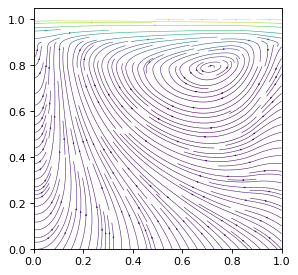

[311] loss =    84.7813187 	 26.349s 	 less than 741.711 minutes to finish
[312] loss =    84.2934265 	 26.004s 	 less than 731.585 minutes to finish
[313] loss =    83.8147659 	 25.861s 	 less than 727.120 minutes to finish
[314] loss =    83.3445969 	 26.006s 	 less than 730.757 minutes to finish
[315] loss =    82.8834152 	 26.542s 	 less than 745.391 minutes to finish
[316] loss =    82.4304810 	 26.124s 	 less than 733.214 minutes to finish
[317] loss =    81.9861298 	 26.057s 	 less than 730.892 minutes to finish
[318] loss =    81.5496750 	 26.105s 	 less than 731.820 minutes to finish
[319] loss =    81.1211090 	 25.673s 	 less than 719.263 minutes to finish
[320] loss =    80.7005234 	 25.770s 	 less than 721.568 minutes to finish


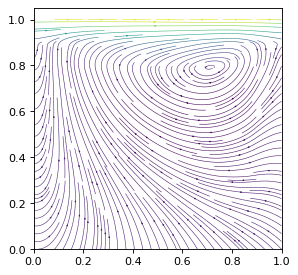

[321] loss =    80.2872238 	 26.228s 	 less than 733.935 minutes to finish
[322] loss =    79.8816910 	 26.348s 	 less than 736.860 minutes to finish
[323] loss =    79.4834366 	 26.773s 	 less than 748.293 minutes to finish
[324] loss =    79.0925827 	 26.214s 	 less than 732.256 minutes to finish
[325] loss =    78.7088089 	 26.232s 	 less than 732.304 minutes to finish
[326] loss =    78.3321152 	 26.688s 	 less than 744.603 minutes to finish
[327] loss =    77.9625244 	 26.012s 	 less than 725.297 minutes to finish
[328] loss =    77.5998535 	 26.360s 	 less than 734.566 minutes to finish
[329] loss =    77.2433853 	 25.966s 	 less than 723.148 minutes to finish
[330] loss =    76.8940735 	 26.420s 	 less than 735.346 minutes to finish


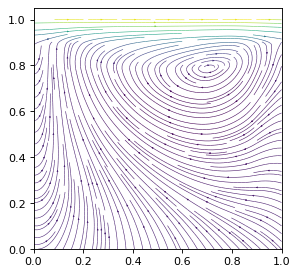

[331] loss =    76.5510254 	 26.292s 	 less than 731.350 minutes to finish
[332] loss =    76.2145996 	 26.645s 	 less than 740.718 minutes to finish
[333] loss =    75.8839417 	 26.166s 	 less than 726.967 minutes to finish
[334] loss =    75.5596924 	 26.588s 	 less than 738.252 minutes to finish
[335] loss =    75.2417755 	 26.511s 	 less than 735.680 minutes to finish
[336] loss =    74.9289932 	 26.265s 	 less than 728.415 minutes to finish
[337] loss =    74.6223755 	 26.386s 	 less than 731.319 minutes to finish
[338] loss =    74.3208466 	 26.705s 	 less than 739.741 minutes to finish
[339] loss =    74.0247650 	 26.455s 	 less than 732.363 minutes to finish
[340] loss =    73.7340698 	 26.386s 	 less than 730.011 minutes to finish


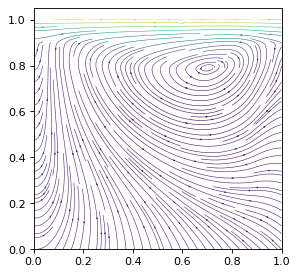

[341] loss =    73.4482498 	 26.584s 	 less than 735.058 minutes to finish
[342] loss =    73.1674805 	 26.303s 	 less than 726.850 minutes to finish
[343] loss =    72.8911514 	 25.666s 	 less than 708.796 minutes to finish
[344] loss =    72.6193771 	 26.171s 	 less than 722.324 minutes to finish
[345] loss =    72.3520050 	 26.169s 	 less than 721.826 minutes to finish
[346] loss =    72.0891342 	 26.382s 	 less than 727.253 minutes to finish
[347] loss =    71.8297958 	 26.389s 	 less than 727.026 minutes to finish
[348] loss =    71.5748825 	 26.420s 	 less than 727.424 minutes to finish
[349] loss =    71.3233566 	 26.548s 	 less than 730.524 minutes to finish
[350] loss =    71.0760040 	 26.828s 	 less than 737.778 minutes to finish


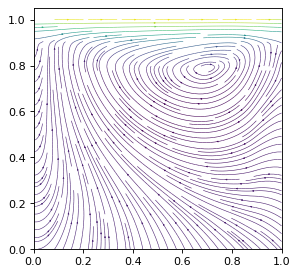

[351] loss =    70.8321457 	 26.431s 	 less than 726.411 minutes to finish
[352] loss =    70.5918655 	 26.506s 	 less than 728.029 minutes to finish
[353] loss =    70.3545685 	 26.074s 	 less than 715.741 minutes to finish
[354] loss =    70.1210175 	 26.062s 	 less than 714.960 minutes to finish
[355] loss =    69.8902664 	 26.068s 	 less than 714.694 minutes to finish
[356] loss =    69.6624374 	 26.332s 	 less than 721.503 minutes to finish
[357] loss =    69.4382095 	 26.225s 	 less than 718.136 minutes to finish
[358] loss =    69.2160873 	 26.148s 	 less than 715.586 minutes to finish
[359] loss =    68.9970093 	 26.366s 	 less than 721.103 minutes to finish
[360] loss =    68.7809143 	 26.635s 	 less than 728.029 minutes to finish


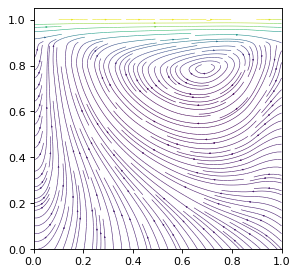

[361] loss =    68.5672150 	 27.017s 	 less than 738.001 minutes to finish
[362] loss =    68.3560791 	 26.770s 	 less than 730.821 minutes to finish
[363] loss =    68.1480637 	 26.448s 	 less than 721.594 minutes to finish
[364] loss =    67.9419174 	 26.497s 	 less than 722.486 minutes to finish
[365] loss =    67.7389145 	 26.511s 	 less than 722.422 minutes to finish
[366] loss =    67.5373230 	 26.019s 	 less than 708.575 minutes to finish
[367] loss =    67.3385162 	 25.613s 	 less than 697.096 minutes to finish
[368] loss =    67.1421204 	 26.097s 	 less than 709.847 minutes to finish
[369] loss =    66.9483185 	 25.959s 	 less than 705.663 minutes to finish
[370] loss =    66.7561340 	 26.002s 	 less than 706.383 minutes to finish


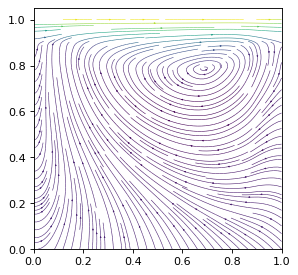

[371] loss =    66.5667725 	 26.111s 	 less than 708.923 minutes to finish
[372] loss =    66.3791580 	 26.149s 	 less than 709.507 minutes to finish
[373] loss =    66.1937256 	 26.658s 	 less than 722.884 minutes to finish
[374] loss =    66.0106201 	 26.075s 	 less than 706.620 minutes to finish
[375] loss =    65.8289566 	 26.249s 	 less than 710.918 minutes to finish
[376] loss =    65.6502380 	 25.789s 	 less than 698.018 minutes to finish
[377] loss =    65.4732056 	 26.325s 	 less than 712.105 minutes to finish
[378] loss =    65.2979736 	 26.960s 	 less than 728.820 minutes to finish
[379] loss =    65.1252823 	 26.443s 	 less than 714.393 minutes to finish
[380] loss =    64.9541626 	 26.063s 	 less than 703.710 minutes to finish


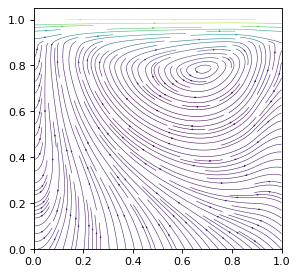

[381] loss =    64.7847443 	 25.920s 	 less than 699.407 minutes to finish
[382] loss =    64.6177063 	 26.180s 	 less than 705.990 minutes to finish
[383] loss =    64.4525986 	 26.250s 	 less than 707.427 minutes to finish
[384] loss =    64.2889862 	 26.345s 	 less than 709.561 minutes to finish
[385] loss =    64.1274414 	 26.388s 	 less than 710.274 minutes to finish
[386] loss =    63.9675636 	 25.564s 	 less than 687.684 minutes to finish
[387] loss =    63.8098373 	 25.656s 	 less than 689.729 minutes to finish
[388] loss =    63.6543617 	 26.158s 	 less than 702.784 minutes to finish
[389] loss =    63.4999733 	 26.222s 	 less than 704.053 minutes to finish
[390] loss =    63.3472404 	 26.039s 	 less than 698.710 minutes to finish


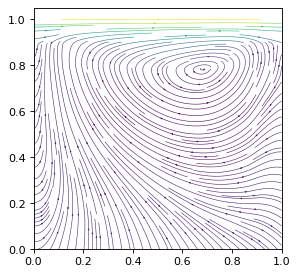

[391] loss =    63.1969681 	 26.635s 	 less than 714.264 minutes to finish
[392] loss =    63.0476379 	 26.591s 	 less than 712.626 minutes to finish
[393] loss =    62.9002304 	 26.327s 	 less than 705.138 minutes to finish
[394] loss =    62.7547150 	 26.422s 	 less than 707.237 minutes to finish
[395] loss =    62.6105652 	 26.523s 	 less than 709.488 minutes to finish
[396] loss =    62.4684792 	 26.255s 	 less than 701.874 minutes to finish
[397] loss =    62.3277893 	 25.889s 	 less than 691.671 minutes to finish
[398] loss =    62.1888428 	 26.377s 	 less than 704.268 minutes to finish
[399] loss =    62.0510635 	 26.197s 	 less than 699.022 minutes to finish
[400] loss =    61.9151421 	 26.077s 	 less than 695.392 minutes to finish


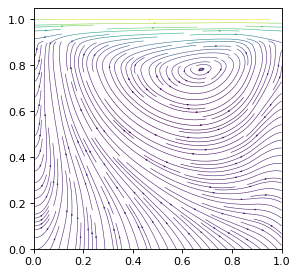

[401] loss =    61.7807541 	 26.194s 	 less than 698.065 minutes to finish
[402] loss =    61.6477890 	 25.784s 	 less than 686.726 minutes to finish
[403] loss =    61.5164909 	 26.309s 	 less than 700.249 minutes to finish
[404] loss =    61.3869019 	 25.935s 	 less than 689.864 minutes to finish
[405] loss =    61.2585030 	 25.686s 	 less than 682.811 minutes to finish
[406] loss =    61.1313972 	 26.368s 	 less than 700.511 minutes to finish
[407] loss =    61.0056305 	 26.204s 	 less than 695.727 minutes to finish
[408] loss =    60.8809090 	 26.317s 	 less than 698.285 minutes to finish
[409] loss =    60.7585373 	 26.560s 	 less than 704.290 minutes to finish
[410] loss =    60.6366768 	 26.356s 	 less than 698.422 minutes to finish


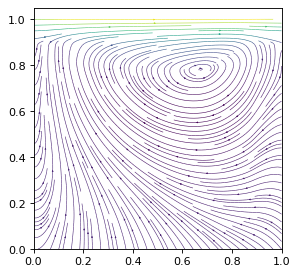

[411] loss =    60.5160217 	 26.491s 	 less than 701.558 minutes to finish
[412] loss =    60.3979073 	 26.419s 	 less than 699.235 minutes to finish
[413] loss =    60.2795105 	 26.359s 	 less than 697.195 minutes to finish
[414] loss =    60.1633072 	 26.690s 	 less than 705.497 minutes to finish
[415] loss =    60.0486450 	 26.240s 	 less than 693.180 minutes to finish
[416] loss =    59.9340897 	 26.471s 	 less than 698.832 minutes to finish
[417] loss =    59.8218613 	 26.312s 	 less than 694.201 minutes to finish
[418] loss =    59.7103882 	 26.231s 	 less than 691.626 minutes to finish
[419] loss =    59.5998230 	 26.536s 	 less than 699.232 minutes to finish
[420] loss =    59.4909172 	 26.793s 	 less than 705.545 minutes to finish


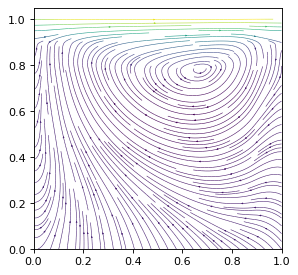

[421] loss =    59.3832741 	 26.406s 	 less than 694.928 minutes to finish
[422] loss =    59.2756081 	 26.741s 	 less than 703.285 minutes to finish
[423] loss =    59.1702881 	 26.100s 	 less than 685.984 minutes to finish
[424] loss =    59.0659943 	 26.292s 	 less than 690.600 minutes to finish
[425] loss =    58.9622879 	 26.107s 	 less than 685.308 minutes to finish
[426] loss =    58.8594093 	 26.240s 	 less than 688.375 minutes to finish
[427] loss =    58.7582321 	 26.295s 	 less than 689.362 minutes to finish
[428] loss =    58.6577644 	 26.195s 	 less than 686.299 minutes to finish
[429] loss =    58.5581703 	 26.578s 	 less than 695.900 minutes to finish
[430] loss =    58.4603271 	 26.150s 	 less than 684.267 minutes to finish


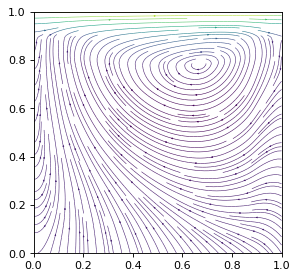

[431] loss =    58.3630981 	 26.784s 	 less than 700.397 minutes to finish
[432] loss =    58.2664452 	 26.535s 	 less than 693.458 minutes to finish
[433] loss =    58.1707878 	 26.336s 	 less than 687.805 minutes to finish
[434] loss =    58.0766792 	 26.569s 	 less than 693.455 minutes to finish
[435] loss =    57.9830856 	 26.360s 	 less than 687.553 minutes to finish
[436] loss =    57.8901901 	 26.407s 	 less than 688.353 minutes to finish
[437] loss =    57.7986755 	 26.110s 	 less than 680.160 minutes to finish
[438] loss =    57.7082596 	 26.076s 	 less than 678.839 minutes to finish
[439] loss =    57.6179962 	 26.531s 	 less than 690.241 minutes to finish
[440] loss =    57.5286713 	 26.490s 	 less than 688.736 minutes to finish


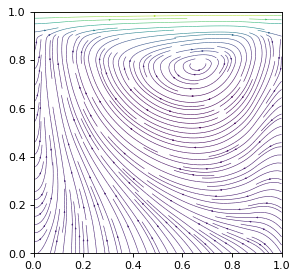

[441] loss =    57.4405708 	 26.731s 	 less than 694.572 minutes to finish
[442] loss =    57.3536491 	 26.244s 	 less than 681.460 minutes to finish
[443] loss =    57.2673988 	 26.124s 	 less than 677.916 minutes to finish
[444] loss =    57.1811409 	 26.330s 	 less than 682.830 minutes to finish
[445] loss =    57.0964775 	 26.007s 	 less than 674.023 minutes to finish
[446] loss =    57.0126991 	 26.391s 	 less than 683.534 minutes to finish
[447] loss =    56.9299469 	 25.917s 	 less than 670.817 minutes to finish
[448] loss =    56.8475761 	 26.339s 	 less than 681.308 minutes to finish
[449] loss =    56.7659683 	 25.689s 	 less than 664.070 minutes to finish
[450] loss =    56.6851578 	 25.866s 	 less than 668.195 minutes to finish


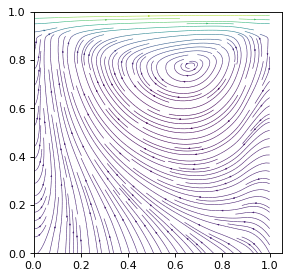

[451] loss =    56.6047249 	 25.923s 	 less than 669.245 minutes to finish
[452] loss =    56.5251083 	 26.160s 	 less than 674.933 minutes to finish
[453] loss =    56.4464111 	 25.860s 	 less than 666.744 minutes to finish
[454] loss =    56.3694458 	 26.227s 	 less than 675.778 minutes to finish
[455] loss =    56.2918167 	 26.029s 	 less than 670.239 minutes to finish
[456] loss =    56.2156410 	 26.248s 	 less than 675.441 minutes to finish
[457] loss =    56.1398621 	 26.607s 	 less than 684.255 minutes to finish
[458] loss =    56.0648689 	 26.583s 	 less than 683.183 minutes to finish
[459] loss =    55.9905663 	 25.990s 	 less than 667.504 minutes to finish
[460] loss =    55.9171982 	 26.076s 	 less than 669.294 minutes to finish


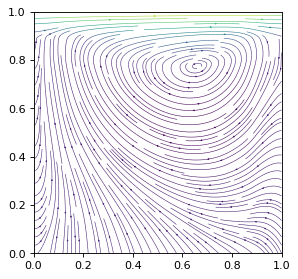

[461] loss =    55.8442268 	 26.325s 	 less than 675.237 minutes to finish
[462] loss =    55.7714653 	 26.331s 	 less than 674.961 minutes to finish
[463] loss =    55.7002678 	 26.046s 	 less than 667.202 minutes to finish
[464] loss =    55.6287537 	 25.985s 	 less than 665.217 minutes to finish
[465] loss =    55.5585747 	 26.386s 	 less than 675.041 minutes to finish
[466] loss =    55.4886131 	 26.418s 	 less than 675.419 minutes to finish
[467] loss =    55.4198494 	 26.305s 	 less than 672.089 minutes to finish
[468] loss =    55.3516235 	 25.992s 	 less than 663.653 minutes to finish
[469] loss =    55.2829208 	 26.341s 	 less than 672.144 minutes to finish
[470] loss =    55.2163353 	 26.000s 	 less than 662.998 minutes to finish


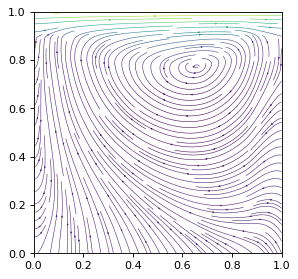

[471] loss =    55.1495514 	 25.986s 	 less than 662.206 minutes to finish
[472] loss =    55.0829353 	 25.952s 	 less than 660.923 minutes to finish
[473] loss =    55.0175362 	 25.904s 	 less than 659.253 minutes to finish
[474] loss =    54.9523582 	 26.146s 	 less than 664.980 minutes to finish
[475] loss =    54.8881454 	 26.256s 	 less than 667.335 minutes to finish
[476] loss =    54.8245277 	 26.059s 	 less than 661.902 minutes to finish
[477] loss =    54.7607689 	 26.310s 	 less than 667.824 minutes to finish
[478] loss =    54.6984329 	 26.603s 	 less than 674.836 minutes to finish
[479] loss =    54.6361046 	 26.585s 	 less than 673.924 minutes to finish
[480] loss =    54.5740166 	 26.262s 	 less than 665.292 minutes to finish


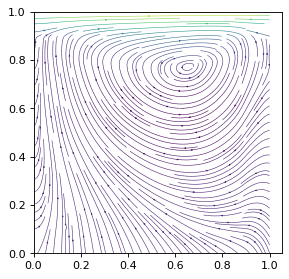

[481] loss =    54.5125542 	 27.022s 	 less than 684.097 minutes to finish
[482] loss =    54.4523621 	 26.083s 	 less than 659.899 minutes to finish
[483] loss =    54.3920212 	 26.186s 	 less than 662.060 minutes to finish
[484] loss =    54.3324318 	 26.314s 	 less than 664.866 minutes to finish
[485] loss =    54.2734299 	 26.316s 	 less than 664.469 minutes to finish
[486] loss =    54.2146645 	 26.153s 	 less than 659.932 minutes to finish
[487] loss =    54.1564713 	 26.465s 	 less than 667.367 minutes to finish
[488] loss =    54.0981903 	 26.088s 	 less than 657.430 minutes to finish
[489] loss =    54.0408936 	 26.169s 	 less than 659.024 minutes to finish
[490] loss =    53.9845200 	 26.076s 	 less than 656.250 minutes to finish


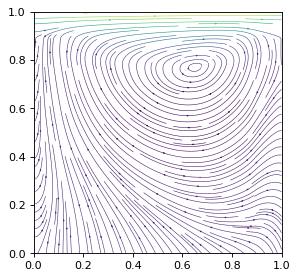

[491] loss =    53.9276314 	 26.437s 	 less than 664.896 minutes to finish
[492] loss =    53.8718948 	 26.609s 	 less than 668.785 minutes to finish
[493] loss =    53.8166847 	 26.552s 	 less than 666.889 minutes to finish
[494] loss =    53.7620659 	 26.755s 	 less than 671.539 minutes to finish
[495] loss =    53.7074738 	 26.225s 	 less than 657.803 minutes to finish
[496] loss =    53.6529007 	 26.284s 	 less than 658.857 minutes to finish
[497] loss =    53.5998993 	 26.418s 	 less than 661.764 minutes to finish
[498] loss =    53.5459938 	 26.680s 	 less than 667.893 minutes to finish
[499] loss =    53.4934120 	 26.413s 	 less than 660.768 minutes to finish
[500] loss =    53.4409828 	 26.004s 	 less than 650.099 minutes to finish


[501] loss =    53.3888397 	 25.868s 	 less than 646.264 minutes to finish
[502] loss =    53.3372650 	 26.037s 	 less than 650.050 minutes to finish
[503] loss =    53.2861671 	 26.557s 	 less than 662.599 minutes to finish
[504] loss =    53.2347031 	 26.166s 	 less than 652.413 minutes to finish
[505] loss =    53.1848946 	 26.364s 	 less than 656.911 minutes to finish
[506] loss =    53.1348534 	 26.683s 	 less than 664.416 minutes to finish
[507] loss =    53.0849838 	 26.148s 	 less than 650.655 minutes to finish
[508] loss =    53.0356102 	 26.417s 	 less than 656.905 minutes to finish
[509] loss =    52.9867249 	 25.809s 	 less than 641.361 minutes to finish
[510] loss =    52.9383202 	 26.185s 	 less than 650.259 minutes to finish


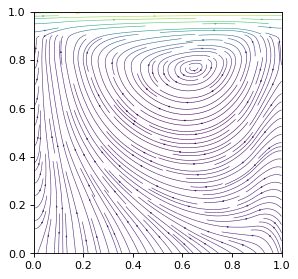

[511] loss =    52.8902168 	 26.043s 	 less than 646.296 minutes to finish
[512] loss =    52.8426323 	 26.107s 	 less than 647.446 minutes to finish
[513] loss =    52.7951813 	 26.399s 	 less than 654.255 minutes to finish
[514] loss =    52.7478752 	 26.126s 	 less than 647.053 minutes to finish
[515] loss =    52.7009468 	 26.346s 	 less than 652.056 minutes to finish
[516] loss =    52.6547241 	 26.163s 	 less than 647.106 minutes to finish
[517] loss =    52.6082230 	 25.794s 	 less than 637.536 minutes to finish
[518] loss =    52.5628510 	 26.096s 	 less than 644.567 minutes to finish
[519] loss =    52.5175819 	 26.541s 	 less than 655.118 minutes to finish
[520] loss =    52.4723778 	 25.956s 	 less than 640.237 minutes to finish


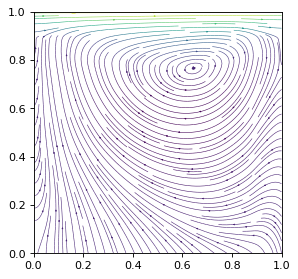

[521] loss =    52.4275665 	 26.553s 	 less than 654.535 minutes to finish
[522] loss =    52.3834915 	 26.799s 	 less than 660.149 minutes to finish
[523] loss =    52.3390160 	 26.191s 	 less than 644.732 minutes to finish
[524] loss =    52.2952652 	 26.133s 	 less than 642.875 minutes to finish
[525] loss =    52.2517204 	 26.160s 	 less than 643.111 minutes to finish
[526] loss =    52.2088699 	 26.351s 	 less than 647.368 minutes to finish
[527] loss =    52.1660919 	 26.544s 	 less than 651.644 minutes to finish
[528] loss =    52.1236382 	 26.530s 	 less than 650.876 minutes to finish
[529] loss =    52.0806465 	 26.255s 	 less than 643.686 minutes to finish
[530] loss =    52.0393066 	 26.470s 	 less than 648.520 minutes to finish


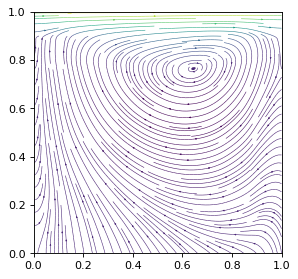

[531] loss =    51.9975548 	 27.030s 	 less than 661.779 minutes to finish
[532] loss =    51.9552917 	 26.321s 	 less than 643.995 minutes to finish
[533] loss =    51.9151421 	 25.972s 	 less than 635.010 minutes to finish
[534] loss =    51.8743858 	 26.189s 	 less than 639.886 minutes to finish
[535] loss =    51.8336334 	 26.148s 	 less than 638.458 minutes to finish
[536] loss =    51.7932892 	 26.568s 	 less than 648.255 minutes to finish
[537] loss =    51.7534294 	 25.856s 	 less than 630.448 minutes to finish
[538] loss =    51.7137756 	 26.184s 	 less than 638.028 minutes to finish
[539] loss =    51.6741524 	 26.177s 	 less than 637.419 minutes to finish
[540] loss =    51.6357193 	 26.213s 	 less than 637.842 minutes to finish


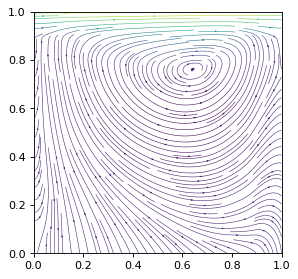

[541] loss =    51.5961304 	 26.497s 	 less than 644.321 minutes to finish
[542] loss =    51.5577583 	 26.188s 	 less than 636.362 minutes to finish
[543] loss =    51.5195465 	 26.101s 	 less than 633.822 minutes to finish
[544] loss =    51.4816628 	 26.329s 	 less than 638.910 minutes to finish
[545] loss =    51.4433098 	 26.647s 	 less than 646.200 minutes to finish
[546] loss =    51.4058533 	 26.626s 	 less than 645.225 minutes to finish

New learning rate: 1e-05
[547] loss =    42.5393944 	 26.182s 	 less than 634.031 minutes to finish
[548] loss =    42.2570267 	 25.901s 	 less than 626.811 minutes to finish
[549] loss =    42.2745132 	 26.112s 	 less than 631.471 minutes to finish
[550] loss =    42.2717133 	 26.553s 	 less than 641.698 minutes to finish


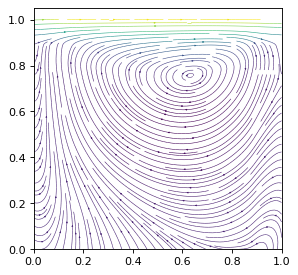

[551] loss =    42.2563019 	 26.652s 	 less than 643.638 minutes to finish
[552] loss =    42.2364616 	 26.366s 	 less than 636.289 minutes to finish
[553] loss =    42.2157822 	 26.816s 	 less than 646.721 minutes to finish
[554] loss =    42.1953735 	 26.315s 	 less than 634.184 minutes to finish
[555] loss =    42.1754875 	 26.394s 	 less than 635.652 minutes to finish
[556] loss =    42.1562080 	 25.712s 	 less than 618.802 minutes to finish
[557] loss =    42.1373901 	 25.341s 	 less than 609.441 minutes to finish
[558] loss =    42.1190414 	 25.691s 	 less than 617.449 minutes to finish
[559] loss =    42.1011810 	 26.147s 	 less than 627.961 minutes to finish
[560] loss =    42.0836258 	 26.562s 	 less than 637.480 minutes to finish


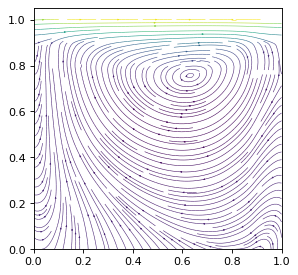

[561] loss =    42.0665016 	 27.024s 	 less than 648.129 minutes to finish
[562] loss =    42.0494118 	 26.429s 	 less than 633.425 minutes to finish
[563] loss =    42.0328140 	 26.454s 	 less than 633.566 minutes to finish
[564] loss =    42.0165901 	 26.077s 	 less than 624.101 minutes to finish
[565] loss =    42.0003204 	 26.617s 	 less than 636.584 minutes to finish
[566] loss =    41.9843330 	 26.248s 	 less than 627.332 minutes to finish
[567] loss =    41.9686852 	 25.840s 	 less than 617.154 minutes to finish
[568] loss =    41.9530258 	 25.905s 	 less than 618.269 minutes to finish
[569] loss =    41.9377518 	 26.254s 	 less than 626.158 minutes to finish
[570] loss =    41.9223213 	 25.672s 	 less than 611.839 minutes to finish


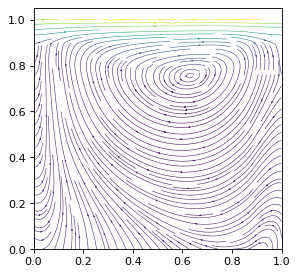

[571] loss =    41.9072151 	 26.037s 	 less than 620.115 minutes to finish
[572] loss =    41.8922348 	 26.624s 	 less than 633.652 minutes to finish
[573] loss =    41.8774223 	 26.596s 	 less than 632.553 minutes to finish
[574] loss =    41.8625107 	 25.980s 	 less than 617.457 minutes to finish
[575] loss =    41.8481293 	 26.137s 	 less than 620.748 minutes to finish
[576] loss =    41.8335915 	 26.027s 	 less than 617.697 minutes to finish
[577] loss =    41.8192596 	 25.710s 	 less than 609.759 minutes to finish
[578] loss =    41.8049049 	 26.253s 	 less than 622.187 minutes to finish
[579] loss =    41.7906380 	 26.148s 	 less than 619.266 minutes to finish
[580] loss =    41.7766647 	 26.262s 	 less than 621.540 minutes to finish


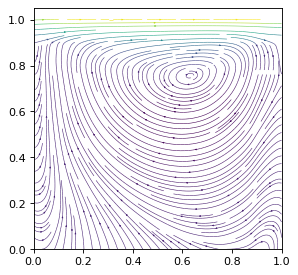

[581] loss =    41.7624855 	 26.081s 	 less than 616.811 minutes to finish
[582] loss =    41.7485619 	 25.926s 	 less than 612.723 minutes to finish
[583] loss =    41.7347183 	 26.074s 	 less than 615.791 minutes to finish
[584] loss =    41.7208862 	 26.097s 	 less than 615.892 minutes to finish
[585] loss =    41.7071037 	 27.012s 	 less than 637.037 minutes to finish
[586] loss =    41.6935158 	 26.032s 	 less than 613.484 minutes to finish
[587] loss =    41.6798973 	 26.331s 	 less than 620.094 minutes to finish
[588] loss =    41.6663284 	 26.134s 	 less than 615.029 minutes to finish
[589] loss =    41.6530991 	 26.041s 	 less than 612.387 minutes to finish
[590] loss =    41.6394196 	 26.922s 	 less than 632.669 minutes to finish


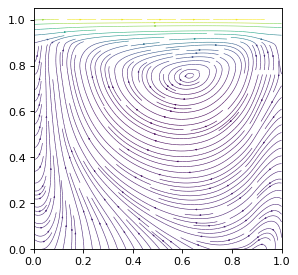

[591] loss =    41.6262245 	 25.738s 	 less than 604.405 minutes to finish
[592] loss =    41.6128769 	 26.044s 	 less than 611.176 minutes to finish
[593] loss =    41.5995903 	 26.102s 	 less than 612.085 minutes to finish
[594] loss =    41.5863457 	 26.298s 	 less than 616.261 minutes to finish
[595] loss =    41.5730934 	 25.845s 	 less than 605.209 minutes to finish
[596] loss =    41.5600471 	 25.735s 	 less than 602.208 minutes to finish
[597] loss =    41.5471382 	 26.441s 	 less than 618.284 minutes to finish
[598] loss =    41.5341454 	 26.586s 	 less than 621.218 minutes to finish
[599] loss =    41.5210724 	 26.202s 	 less than 611.828 minutes to finish
[600] loss =    41.5081863 	 26.441s 	 less than 616.951 minutes to finish


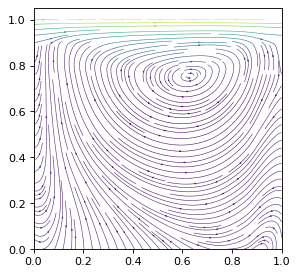

[601] loss =    41.4953270 	 25.823s 	 less than 602.110 minutes to finish
[602] loss =    41.4826241 	 25.967s 	 less than 605.041 minutes to finish
[603] loss =    41.4697456 	 26.008s 	 less than 605.558 minutes to finish
[604] loss =    41.4569130 	 26.112s 	 less than 607.551 minutes to finish
[605] loss =    41.4442444 	 25.961s 	 less than 603.593 minutes to finish
[606] loss =    41.4315338 	 26.088s 	 less than 606.117 minutes to finish
[607] loss =    41.4189377 	 26.233s 	 less than 609.046 minutes to finish
[608] loss =    41.4062691 	 25.699s 	 less than 596.226 minutes to finish
[609] loss =    41.3937569 	 26.103s 	 less than 605.152 minutes to finish
[610] loss =    41.3811302 	 25.896s 	 less than 599.927 minutes to finish


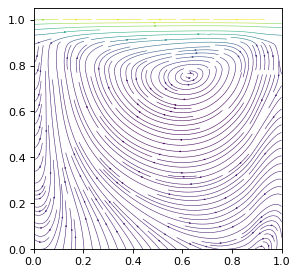

[611] loss =    41.3687210 	 25.923s 	 less than 600.120 minutes to finish
[612] loss =    41.3561554 	 26.089s 	 less than 603.528 minutes to finish
[613] loss =    41.3439217 	 26.017s 	 less than 601.430 minutes to finish
[614] loss =    41.3315353 	 26.111s 	 less than 603.169 minutes to finish
[615] loss =    41.3189163 	 25.883s 	 less than 597.475 minutes to finish
[616] loss =    41.3066330 	 26.853s 	 less than 619.407 minutes to finish
[617] loss =    41.2942924 	 26.119s 	 less than 602.034 minutes to finish
[618] loss =    41.2820473 	 25.828s 	 less than 594.902 minutes to finish
[619] loss =    41.2699013 	 26.786s 	 less than 616.528 minutes to finish
[620] loss =    41.2575264 	 26.713s 	 less than 614.403 minutes to finish


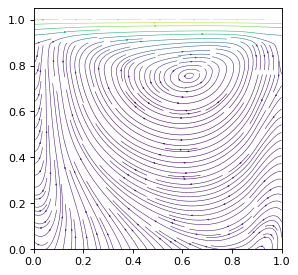

[621] loss =    41.2454262 	 26.569s 	 less than 610.646 minutes to finish
[622] loss =    41.2333908 	 26.120s 	 less than 599.879 minutes to finish
[623] loss =    41.2211990 	 26.202s 	 less than 601.339 minutes to finish
[624] loss =    41.2090454 	 26.070s 	 less than 597.862 minutes to finish
[625] loss =    41.1968040 	 25.812s 	 less than 591.525 minutes to finish
[626] loss =    41.1849937 	 26.194s 	 less than 599.833 minutes to finish
[627] loss =    41.1729240 	 26.098s 	 less than 597.214 minutes to finish
[628] loss =    41.1609154 	 26.492s 	 less than 605.793 minutes to finish
[629] loss =    41.1489677 	 26.433s 	 less than 603.984 minutes to finish
[630] loss =    41.1370010 	 26.508s 	 less than 605.270 minutes to finish


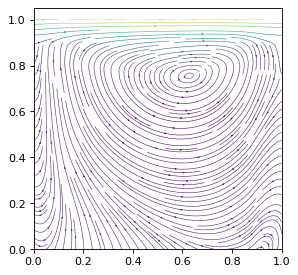

[631] loss =    41.1250725 	 26.185s 	 less than 597.462 minutes to finish
[632] loss =    41.1131020 	 26.523s 	 less than 604.727 minutes to finish
[633] loss =    41.1012611 	 26.517s 	 less than 604.138 minutes to finish
[634] loss =    41.0893745 	 26.162s 	 less than 595.612 minutes to finish
[635] loss =    41.0776405 	 26.452s 	 less than 601.779 minutes to finish
[636] loss =    41.0656319 	 26.348s 	 less than 598.987 minutes to finish
[637] loss =    41.0539894 	 26.388s 	 less than 599.451 minutes to finish
[638] loss =    41.0422325 	 26.462s 	 less than 600.683 minutes to finish
[639] loss =    41.0304756 	 25.742s 	 less than 583.922 minutes to finish
[640] loss =    41.0187798 	 26.517s 	 less than 601.058 minutes to finish


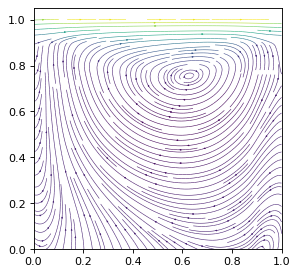

[641] loss =    41.0072098 	 26.495s 	 less than 600.119 minutes to finish
[642] loss =    40.9955139 	 26.278s 	 less than 594.761 minutes to finish
[643] loss =    40.9836693 	 26.202s 	 less than 592.609 minutes to finish
[644] loss =    40.9721184 	 26.520s 	 less than 599.356 minutes to finish
[645] loss =    40.9605064 	 25.985s 	 less than 586.825 minutes to finish
[646] loss =    40.9488945 	 26.525s 	 less than 598.583 minutes to finish
[647] loss =    40.9372635 	 26.477s 	 less than 597.058 minutes to finish
[648] loss =    40.9256821 	 26.047s 	 less than 586.935 minutes to finish
Total time: 285.96 minutes


In [ ]:
# TRAIN
i = 0
lr = 1e-3
max_ite = 2000
start = time.time()
print("Learning rate:", lr)
while(True):
    start_ite = time.time()
    train(lr)
    if(i%1 == 0):
        print("[%3s] loss = %13.7f \t %5.3fs \t less than %5.3f minutes to finish" % (i, losses[i], time.time() - start_ite, (time.time() - start_ite)*(max_ite - i)/60))
    if(i%10 == 0):
        show(T)
    if(i > 200):
        if(losses[i]/np.min(losses[i-200: i-100]) > 0.9):
            lr = lr/10
            if(lr < 1e-5):
                break
            print("\nNew learning rate:", lr)
    if(losses[i] < 0.1):
        break
    if(i > max_ite):
        break
    i = i + 1


print("Total time: %.2f minutes" % ((time.time() - start)/60))

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/5. NV (multiple steps) (continuous) (Tung)/nv.h5")

In [ ]:
model1 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/5. NV (multiple steps) (continuous) (Tung)/nv.h5")